 Dans ce notebook , je passerai en revue les différentes approches qui j'ai envisagé pour la modélisation , les contraintes techniques rencontrées ainsi que les résultats obtenus. le plan de ce notebook est ci-dessous:

* 1- Analyse exploratoire des données
* 2- Features Engineering
* 3- Modélisation et comparaison des résultats
* 4-Conclusion
* 5-Perspectives

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Read pickle file
df=pd.read_pickle('C:/Users/JIHED/Desktop/Kaggle/commune_scoring.pkl')

## Analyse exploratoire des données

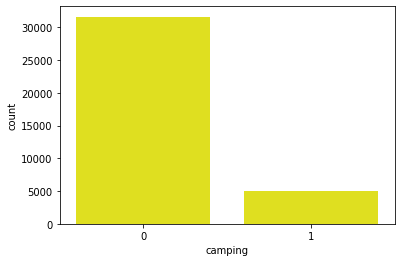

In [3]:
#variable d'intérêt: camping
#Check for imbalanced data
sns.countplot(df['camping'],color='yellow')

Une première vision de cette distribution nous a permis de conclure qu'on est en face à deux classes qui ne sont pas équilibrées.

In [4]:
df1=df.copy() 
#missing data 
missing_total = df.isnull().sum().sort_values(ascending=False)
Pourcentage = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([missing_total, Pourcentage], axis=1, keys=['missing_total', 'Pourcentage'])
#missing_data.head(20)

Les valeurs null réprésentent en tout  presque 1% de l'intégralité de la dataSet.Une première approximation consiste donc à les éliminer (de plus certaines valeurs ne peuvent pas être estimées approchées d'une manière ou d'une autre)

In [5]:
df1=df1.dropna() # drop all Null values
df1=df1.drop(columns=['dep','libgeo','codgeo','cp'],axis=1) # drop dep, libgeo, codgeo, cp (code postal) ->Replicated data
df1.shape

(36550, 92)

In [6]:
#Subdivision des données quantitatives et qualitatives 

# données dont le dtype est différent d'object
data_f = [f for f in df1.columns if df1.dtypes[f] != 'object']

#Données dont le dtype est object
Seems_categorical_f = [f for f in df1.columns if df1.dtypes[f] == 'object']

In [7]:
#Changement l'intégralité des données quantitatives en float (Garantir l'Homogénité)
df1[data_f]=df1[data_f].astype(float)
df1[data_f].shape

(36550, 82)

J'ai anticipé à éliminer les colonnes dupliquées dès le départ.Pour certains classifiers, le fait d'avoir une réplique des colonnes peut majoritairement affecter la prédiction sauf pour RandomForest et Extratree, qui performent même si il y'a une multicolinéarité tout en éliminant les colonnes dupliquées automatiquement.   

In [8]:
# Fonction pour l'élimination des colonnes dupliquées

def getDuplicateC(df):
    '''
    Obtenir une list des colonnes dupliquées
    la fonction permet d'itérer sur toutes les colonnes et essaye de trouver toutes les données identiques.
    variable d'entrée: Dataframe 
    Variable de sortie: Liste des colonnes avec des données dupliquées.
    '''
    duplicate = set()
    # Itération sur toutes les colonnes
    for x in range(df.shape[1]):
        # Selection de x ième index de la colonne
        col = df.iloc[:, x]
        # itération à partir de (x+1) pour tester s'il y'a des données identiques
        for y in range(x + 1, df.shape[1]):
            # selection d'une colonne y pour la comparaison.
            otherCol = df.iloc[:, y]
            # VErification si toutes les données associées à X et Y sont égale à un même index
            if col.equals(otherCol):
                duplicate.add(df.columns.values[y])
 
    return list(duplicate)

In [9]:
duplicateC = getDuplicateC(df1[data_f])
print('Duplicate Columns are as follows')
for col in duplicateC:
    print('Column name : ', col)

Duplicate Columns are as follows
Column name :  capacite_fiscale
Column name :  nb_pharmaciens_liberaux_bv


In [10]:
#Is_duplicate drop columns
df1=df1.drop(columns=['capacite_fiscale','nb_pharmaciens_liberaux_bv'],axis=1)

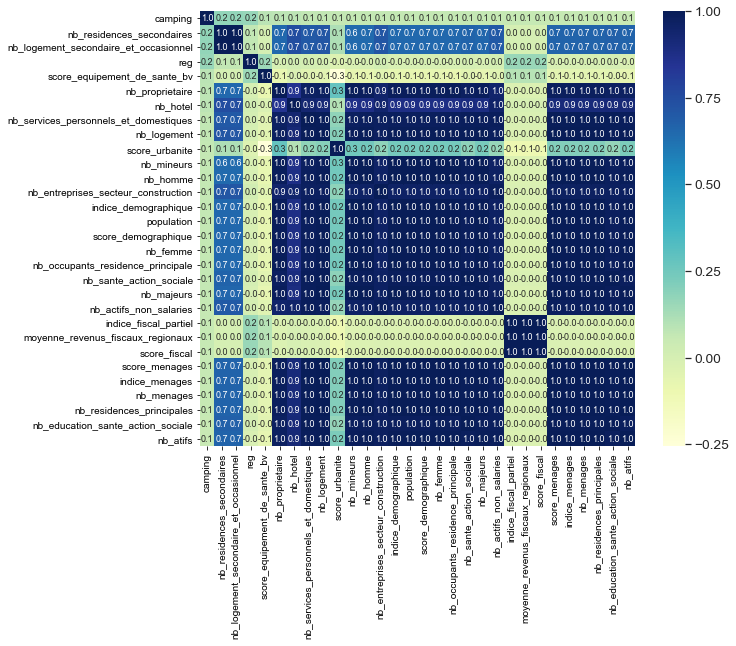

In [11]:
#Determination des n features en forte correlation avec camping (C'est relatif)
data_f2=[f for f in df1.columns if df1.dtypes[f] != 'object']
n = 30 # n tested list to visualize heatmap [15,20,45,60,70,82]
f, ax = plt.subplots(figsize=(10, 8))
df2=df1[data_f2].corr()
cols = df2.nlargest(n, 'camping')['camping'].index
cm = np.corrcoef(df1[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap="YlGnBu", cbar=True, annot=True, square=True, fmt='.1f', annot_kws={'size': 9}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Heatmap demeure le bon moyen pour identifier les relations entre les différentes features. 
A première vue, on pourrait tirer les interprétations suivantes:
* Toutes les données sont pratiquement en corrélation faible avec camping, que ce soit positivement ou négativement.
* On distingue majoritairement que les deux colonnes "nb_logement_secondaire_et_occasionnel" et "nb_residences_secondaires" sont en corrélation forte avec plusieurs autres features (**multicolinéarité**). Ceci dit, qu'il n'y a pas une dépendance absolue mais on pourrait assigner le comportement de cet ensemble aux deux colonnes. De ce fait, toutes les colonnes qui seront en forte corrélation avec ces dernières ne seront pas considérées dans le reste de l'exercice (Etude approximative).
* Une fine étude entre les deux colonnes "nb_residences_secondaires" et "nb_logement_secondaire_et_occasionnel"
  m'as permis de considérer uniquement la deuxième: les deux ont la même distribution indépendamment de la **variance** prodiguée par celles-ci.


In [12]:
'''
Feature_Selection
Critère: sélectionner toutes les colonnes qui sont en faible corrélation avec la colonne "nb_residences_secondaires" dont leur
coefficient de corrélation est entre -0.6 et 0.6.
'''
cols=df2.nlargest(len(data_f2), 'nb_logement_secondaire_et_occasionnel')['nb_logement_secondaire_et_occasionnel'].index
df2=df1[data_f2].corr()
df2.head(5)
cols_corr=df2.loc[(df2.nb_logement_secondaire_et_occasionnel < 0.6) & (df2.nb_logement_secondaire_et_occasionnel > -0.6),'nb_logement_secondaire_et_occasionnel'].index
#cols_corr

In [13]:
# Concaténation des données quantitatives et qualitives (Final DataSet to be performed either for encoding or sample engineering function)
cols_2=['nb_residences_secondaires','nb_logement_secondaire_et_occasionnel']
#df1[Seems_categorical_f].head(10)
columns_train=[df1[cols_2],df1[cols_corr],df1[Seems_categorical_f]]
data_train = pd.concat(columns_train,axis=1)
df1=data_train
#df1.head(5)

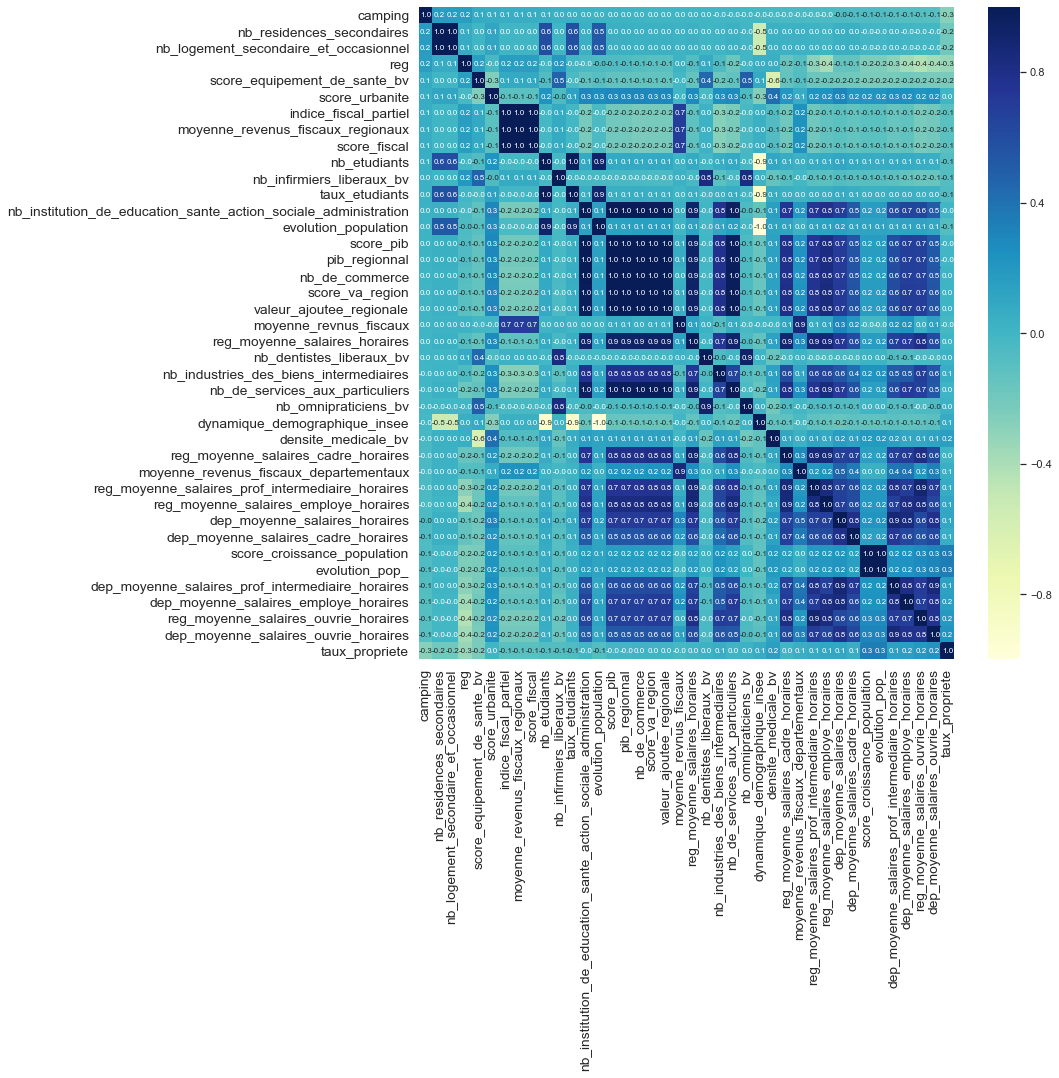

In [14]:
#Reboucler avec la matrice de corrélation pour apercevoir de près la corrélation des différents features avec camping

import matplotlib.pyplot as plt
n = len(data_train) # all features will be considered for the new df1 
f, ax = plt.subplots(figsize=(12, 12))
df2=df1.corr()
cols = df2.nlargest(n, 'camping')['camping'].index 
cm = np.corrcoef(df1[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cmap="YlGnBu", cbar=True, annot=True, fmt='.1f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

A partir de cette matrice de corrélation, on pourrait remarqué que **score_pib** est en corrélation forte avec **pib_regional,nb_de_commerce, score_va_region, valeur_ajoutee_regionale, nb_de_services_aux_particuliers et reg_moyonne_salaires_horaires**.Toute de même pour **indice_fiscale_partiel** qui est en corrélation avec **moyenne_revenus_fiscaux_regionaux, score_fiscal**. A partir de là, tous ces features vont être par la suite éliminés.

In [15]:
df1=df1.drop(columns=['pib_regionnal','nb_de_commerce','score_va_region','valeur_ajoutee_regionale','nb_de_services_aux_particuliers',
                      'moyenne_revenus_fiscaux_regionaux','reg_moyenne_salaires_horaires','score_fiscal'],axis=1)

In [16]:
# drop "nb_residences_secondaires"
df1=df1.drop(columns='nb_residences_secondaires',axis=1)

C:\Users\JIHED\Anaconda2\envs\Python35\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


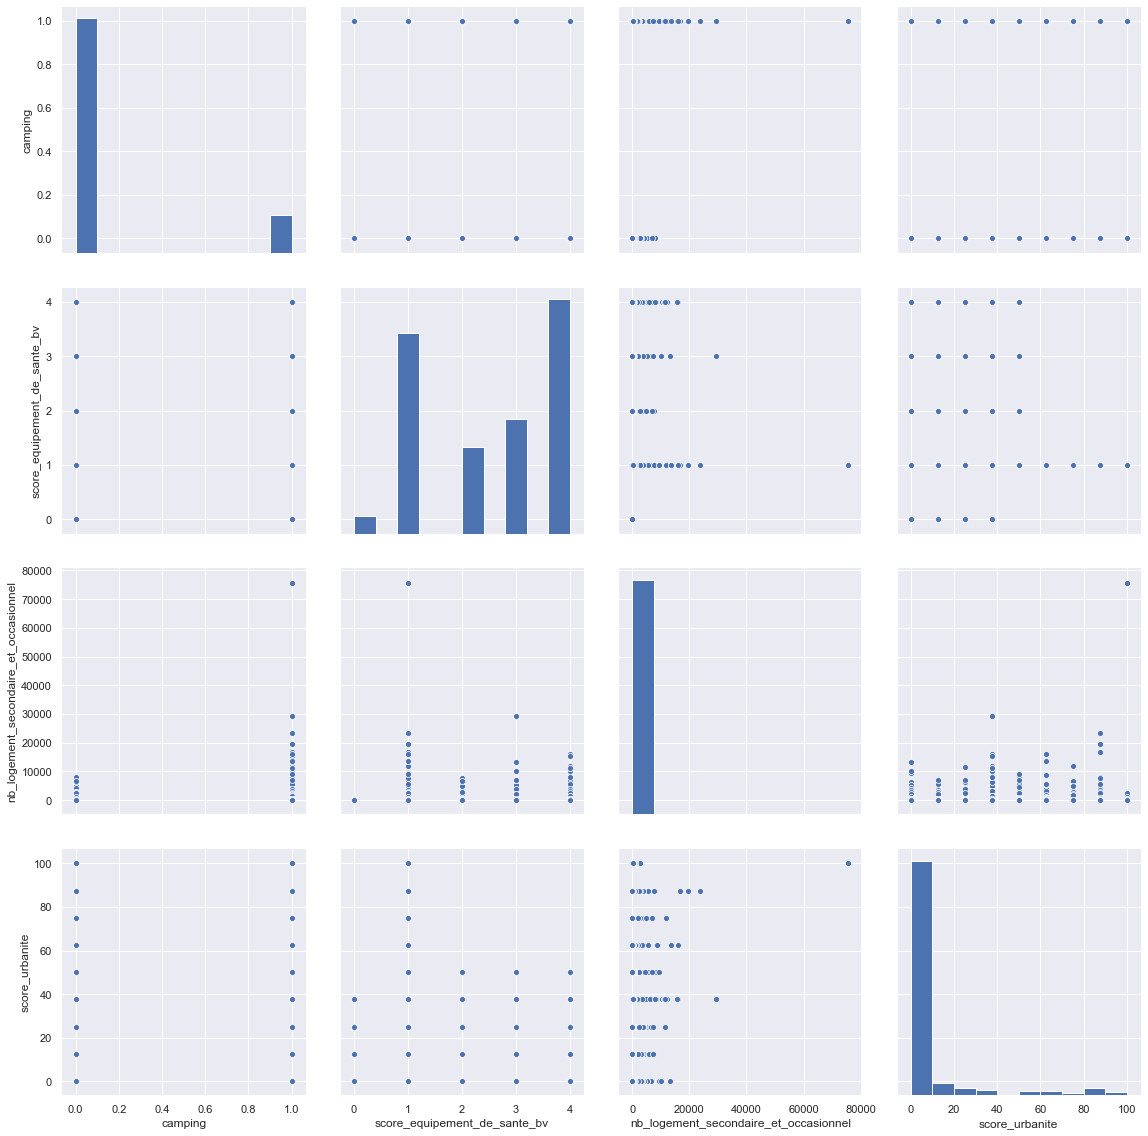

In [17]:
#exploiter sns.pairplot avec une vision particulière pour les features ayant une forte corrélation avec "camping"
#
sns.set()
cols=['camping','score_equipement_de_sante_bv','nb_logement_secondaire_et_occasionnel',
      'score_urbanite']
sns.pairplot(df1[cols],size=4)

A partir des différents plots, on pourrait détecter la présence d'une valeur étrange régie par nb_logement_secondaire_et_occasionnel ~75000  . L'intérêt est d'anéantir tous les outliers de crainte de les avoir dans le data_test et qui pourront éventuellement affecter la précision des prédictions.Comme approche, on va tenir compte uniquement des valeurs de "nb_logement_secondaire_et_occasionnel" qui sont inférieur à 40000.

In [18]:
# ne pas oublier de tracer les courbes
df1=df1[df1.loc[:,'nb_logement_secondaire_et_occasionnel']<40000]
df1['camping']=df1['camping'].astype(int)

## Feature engineering

Intuitivement, on pourrait créer des nouvelles colonnes à l'aide des opérations mathématiques et gagner en taille de la DataFrame.Pour les qualitatives columns, on procède par la suite à leurs encodages soit manuellement ou avec LabelEncoder.
 

In [19]:
# Math Operations
df1['nb_des_metiers_medicaux']=df1['nb_omnipraticiens_bv']+df1['nb_infirmiers_liberaux_bv']+df1['nb_dentistes_liberaux_bv']

df1=df1.drop(columns=['nb_omnipraticiens_bv','nb_infirmiers_liberaux_bv','nb_dentistes_liberaux_bv'])

In [20]:
# Labelling data manually // 
df1['orientation_economique'] = df1['orientation_economique'].map(lambda x: 5 if 'Bassin Résidentiel' in x 
                                                                  else (4 if 'Bassin Urbain' in x 
                                                                        else (3 if 'Bassin Industriel' in x
                                                                             else (2 if 'Bassins Agroalimentaire' in x else 1))))    

In [21]:
'''
Unification des caatégories:
om rurale < 2 000 m habts est majoritairement le centre des data
category[1]= Com < 10 m habts, Com < 50 m habts et Com < 200 m habts sont aggrégés à Com < 2000 m habts
category[0]= Com > 2000 m habts
'''

# Labelling data manually
df1['urbanite_ruralite'] = df1['urbanite_ruralite'].map(lambda x: 0 if 'Com rurale > 2 000 habts' in x else 1)
# then drop it, visiblement, la majorité des valeurs sont pour 0

df1=df1.drop(columns='urbanite_ruralite',axis=1)

In [22]:
#Define a new way of encoding: faible= 1/ moyenne or None =3 /Forte=5

#Labelling syn_medical
df1['syn_medical'] = df1['syn_medical'].map(lambda x: 1 if 'Faible Synergie Médicale' in x 
                                            else (5 if 'Forte Synergie Médicale' in x else 3))
                                                                  
#Labelling seg_cap_fiscale
df1['seg_cap_fiscale'] = df1['seg_cap_fiscale'].map(lambda x: 1 if 'Fiscalité faible' in x 
                                                    else (5 if 'Fiscalité élevée' in x else 3))
                                                                  
#Labelling seg_cap_fiscale
df1['seg_dyn_entre'] = df1['seg_dyn_entre'].map(lambda x: 1 if 'Faible dynamique' in x 
                                                                  else (5 if 'Dynamique Economique' in x else 3))
#Labelling seg_cap_fiscale
df1['dyn_setc'] = df1['dyn_setc'].map(lambda x: 1 if 'Faible Dynamique Serv et Com' in x 
                                                                  else (5 if 'Dynamique Serv et Com' in x else 3)) 
                                                                         

In [23]:
# Le reste des qualitatives features seront encodées avec LabelEncoder
from sklearn.preprocessing import LabelEncoder
cols=['dynamique_demographique_bv','seg_environnement_demographique_obsolete','environnement_demographique','seg_croissance_pop']
for col in cols:
    lbl=LabelEncoder()
    lbl.fit(list(df1[col].values))
    df1[col]=lbl.transform(list(df1[col].values)) 

## Build Models 

In [24]:

#------------------------------Ensemble learning| Classifiers-----------------------------
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
#---------------------------- sklearn metrics--------------------------
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve,auc

#-------------------------Model selection------------------------
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.utils import shuffle
import math


In [ ]:

'''
1- Split data into data_test and data_train
2- J'ai choisi la data_test qui correspond à la première commune qui possède une moyenne de 2.52 (np.average(camping))
: 
          df1.groupby(['reg'], as_index=False).agg({'camping': np.average}).sort_values(by='camping', ascending=False)
           
           -> Rank : (1): commune (93) // admet ue seule ligne
                     (2): commune (53)
                     (3): commune (91)
                                                        '
'''

In [25]:
#Choisir la dataset pour le training correspond aux régions<> 'reg'=11 // just for selection the best model
data_train=df1[df1.reg!=93.0]

#dataset pour la prédiction de la region 11
data_test=df1[df1.reg==93.0]

#Identification des X et Y pour le training
X=data_train.drop('camping',axis=1)
Y=data_train['camping']

#Split_data 
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.1,random_state=42)

In [26]:
# Opter à l'utilisation des folds vue que la distribution de la colonne camping n'est pas uniforme
kfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=0) # folds=5 retenue après avoir tester d'autres

### Model Selection

In [27]:
random_state=42
classifier=RandomForestClassifier(random_state=random_state)
score_RF=np.mean(cross_val_score(classifier, X_train,Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
print('the RF score is {}'.format(score_RF))

the RF score is 0.8915914895359371


In [28]:
random_state=42
classifier=xgb.XGBClassifier(random_state=random_state)
score_XB=np.mean(cross_val_score(classifier, X_train,Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
print('the XB score is {}'.format(score_XB))

the XB score is 0.9000530630558832


In [29]:
random_state=42
classifier=GradientBoostingClassifier(random_state=random_state)
score_GB=np.mean(cross_val_score(classifier, X_train,Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
print('the GB score is {}'.format(score_GB))

the GB score is 0.9003028337748351


In [30]:
random_state=42
classifier=ExtraTreesClassifier(random_state=random_state)
score_ET=np.mean(cross_val_score(classifier, X_train,Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
print('the ET score is {}'.format(score_ET))

the ET score is 0.8830363318151919


In [31]:
classifier=LogisticRegression(C=0.2, solver='sag')
score_LR=np.mean(cross_val_score(classifier, X_train,Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
print('the LR score is {}'.format(score_LR))

the LR score is 0.8811940503670082


In [32]:

random_state=42
classifier=AdaBoostClassifier(random_state=random_state,learning_rate=0.1)
score_ADA=np.mean(cross_val_score(classifier, X_train,Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
print('the ADA score is {}'.format(score_ADA))

the ADA score is 0.8905298920825349


In [33]:
random_state=42
classifier=LinearSVC(random_state=random_state)
score_LSVC=np.mean(cross_val_score(classifier, X_train,Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
print('the LSVC score is {}'.format(score_LSVC))

the LSVC score is 0.7290006173466864


In [34]:
from sklearn.neighbors import KNeighborsClassifier
classifier=KNeighborsClassifier(n_neighbors = 5)
score_KN=np.mean(cross_val_score(classifier, X_train,Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
print('the KN score is {}'.format(score_KN))


the KN score is 0.8878134886717005


In [35]:
classifier=GaussianNB()
score_GNB=np.mean(cross_val_score(classifier, X_train,Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
print('the ET score is {}'.format(score_GNB))

the ET score is 0.8726701864932929


In [36]:
models = pd.DataFrame({
    'Model': ['Random Forest', 'XGBClassifier', 'GRadient Boosting', 
              'Extratrees', 'Logistic Regression', 'Adaboost', 
              'LinearSVC', 'KNN', 
              'GaussianNB'],
    'Score': [score_RF, score_XB, score_GB, 
              score_ET, score_LR, score_ADA, 
              score_LSVC, score_KN, score_GNB]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,GRadient Boosting,0.900303
1,XGBClassifier,0.900053
0,Random Forest,0.891591
5,Adaboost,0.890530
7,KNN,0.887813
3,Extratrees,0.883036
4,Logistic Regression,0.881194
8,GaussianNB,0.872670
6,LinearSVC,0.729001


Hormis que GradientBoosting est désormais le meilleur en terme d'accuracy mais je vais choisir de travailler avec **xgboost** (**Extreme GradientBoosting**) pour la suite de cet exercice (Rapidité de calcul).

In [44]:
# XGBClassifier tunning with GridSearch// Looking for Hyperparamters
XGBC = xgb.XGBClassifier()
classifier_param_grid = {'objective':['binary:logistic'],
              'learning_rate': [0.01,0.05,0.1,0.15,0.2], #so called `eta` value
              'max_depth': [2,4],
              'min_child_weight': [5,11],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [500,1000,1500,2000,2500,3000], #number of trees, idéallement 1000 
              'seed': [1337]}
gsXGBC = GridSearchCV(XGBC,param_grid = classifier_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsXGBC.fit(X_train,Y_train)
GBC_best = gsXGBC.best_estimator_


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  8.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 37.2min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed: 40.0min finished


In [45]:
print(GBC_best)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=11, missing=-999, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337,
              silent=1, subsample=0.8, verbosity=1)


In [46]:
print(gsXGBC.best_score_)

0.8969877721443483


In [37]:
# Classifier based on Hyperparameters
classifier=xgb.XGBClassifier(n_estimators=500,learning_rate=0.05,n_jobs=1,objective='binary:logistic',
                                      booster='gbtree',min_child_weight=11,random_state=0)
classifier.fit(X_train,Y_train)

predicted=classifier.predict(X_test)
proba=classifier.predict_proba(X_test) 
print("Total precision: " + str(1 - np.count_nonzero(Y_test - predicted) / len(Y_test - predicted)))
roc_score=roc_auc_score(Y_test,proba[:,1])
print("roc_auc_score is",roc_score)
print('the Confusion_Matrix is:\n')
print(confusion_matrix(Y_test, predicted))
print('the classification report is:\n')
print(classification_report(Y_test, predicted))

Total precision: 0.8963191907839281
roc_auc_score is 0.8712392795217878
the Confusion_Matrix is:

[[3011   91]
 [ 278  179]]
the classification report is:

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3102
           1       0.66      0.39      0.49       457

    accuracy                           0.90      3559
   macro avg       0.79      0.68      0.72      3559
weighted avg       0.88      0.90      0.88      3559



### Second attempt: Split data into folds and perform xgboost

Dans une perspective d'améliorer la performance de mon modèle face à cette imbalanced situation, j'ai décidé d'utiliser cross_validation pour séparer toutes données suivant des folds avec Xgboost éventuellement.

In [38]:
folds = KFold(n_splits=5, shuffle=True, random_state=0) # folds=5 validé suite à une série de test

precision = []
params = {'n_estimators':500,'learning_rate':0.05,'objective':'binary:logistic','n_jobs':1,
         'booster':'gbtree'}

data_train=df1[df1.reg!=93.0]
X,y = data_train.drop(columns='camping',axis=1),data_train['camping'] 
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.1,random_state=0)

for fold_, (train_idx, valid_idx) in enumerate(folds.split(X,y)):
        print('Fold:',fold_)
        train_x, train_y = X.iloc[train_idx,:], y.values[train_idx]
        valid_x, valid_y = X.iloc[valid_idx,:], y.values[valid_idx]
        print(len(train_x),len(valid_x))
        
        model = xgb.train(params,xgb.DMatrix(train_x, label=train_y), 200, maximize=False)
        #print('Training has finished.')
        #pred = model.predict(xgb.DMatrix(valid_x))  # Test for prediction value
        #pred=np.floor(pred)
        #score_prec=np.round(1-np.count_nonzero(valid_y - pred) / len(valid_y - pred),4)
        #precision.append(score_prec)

Fold: 0
28468 7118
Fold: 1
28469 7117
Fold: 2
28469 7117
Fold: 3
28469 7117
Fold: 4
28469 7117


In [39]:
best_iter = model.best_iteration #Best iteration pour un tel fold

In [40]:
classifier = xgb.XGBClassifier(**params, num_boost_round=best_iter)
classifier.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, num_boost_round=199, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [41]:
# Feature importance après avoir validé qu'avec cette méthode on aurait une meilleure précision
feature_list=list(X_train.columns)
importances=list(classifier.feature_importances_)
feature_importances=[(feature,round(importance,2)) for feature, importance in zip(feature_list, importances)]
# frame with sorted important feature 
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
for feature, importance in feature_importances:
    print('Variable:', feature, end='')
    print(' importance:', importance)

Variable: nb_logement_secondaire_et_occasionnel importance: 0.22
Variable: dyn_setc importance: 0.11
Variable: score_urbanite importance: 0.07
Variable: dep_moyenne_salaires_prof_intermediaire_horaires importance: 0.05
Variable: seg_environnement_demographique_obsolete importance: 0.05
Variable: nb_etudiants importance: 0.03
Variable: dep_moyenne_salaires_employe_horaires importance: 0.03
Variable: dep_moyenne_salaires_ouvrie_horaires importance: 0.03
Variable: reg_moyenne_salaires_cadre_horaires importance: 0.03
Variable: seg_dyn_entre importance: 0.03
Variable: reg importance: 0.02
Variable: score_equipement_de_sante_bv importance: 0.02
Variable: evolution_population importance: 0.02
Variable: reg_moyenne_salaires_prof_intermediaire_horaires importance: 0.02
Variable: taux_propriete importance: 0.02
Variable: moyenne_revnus_fiscaux importance: 0.02
Variable: nb_institution_de_education_sante_action_sociale_administration importance: 0.02
Variable: score_pib importance: 0.02
Variable:

In [42]:
# extract the names of the most important features
important_feature_names=[feature[0] for feature in feature_importances[:16]] # 16: all these important features have been selected
#Select the important indices 
important_indices=[feature_list.index(feature) for feature in important_feature_names]

In [122]:
important_indices

[0, 35, 18, 11, 30, 7, 12, 13, 14, 34, 2, 4, 5, 15, 20, 22]

In [43]:
#Resampling it with important_indice 
X_train_important, y_train_important = X_train.iloc[:,important_indices], Y_train
X_test_important, y_test_important = X_test.iloc[:,important_indices], Y_test

In [44]:
classifier = xgb.XGBClassifier(**params, num_boost_round=best_iter)
classifier.fit(X_train_important, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, num_boost_round=199, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [45]:
prediction_xgb=classifier.predict(X_test_important)
proba=classifier.predict_proba(X_test_important)
roc_score=roc_auc_score(Y_test,proba[:,1])
print("Total precision: " + str(1-np.count_nonzero(y_test_important - prediction_xgb) / len(y_test_important - prediction_xgb)))
print('the roc_auc_score of the fitting is equal to {}'.format(roc_score))
print('the Confusion_Matrix is:\n')
print(confusion_matrix(y_test_important, prediction_xgb))
print('the classification report is:\n')
print(classification_report(y_test_important, prediction_xgb))

Total precision: 0.9008148356279854
the roc_auc_score of the fitting is equal to 0.8819766409271528
the Confusion_Matrix is:

[[2999   68]
 [ 285  207]]
the classification report is:

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      3067
           1       0.75      0.42      0.54       492

    accuracy                           0.90      3559
   macro avg       0.83      0.70      0.74      3559
weighted avg       0.89      0.90      0.89      3559



Comparant avec la première contribution, on pourrait remarquer que dans confusion_matrix que FN and FP ont dimunés, ce qui favorise le recours à ce modèle.[precision, recall et f1_score se sont améliorés]

Hormis qu'on a dubdivisé la dataset into folds, on peut néanmoins remarquer que notre modèle s'est amélioré tout juste dans la mesure de precision et recall qui demeure deux indicateurs important dans la mesure de performance d'un modèle

[0]	validation_0-error:0.108065	validation_0-logloss:0.66081	validation_1-error:0.109862	validation_1-logloss:0.66077
[1]	validation_0-error:0.108065	validation_0-logloss:0.631409	validation_1-error:0.109862	validation_1-logloss:0.631435
[2]	validation_0-error:0.108065	validation_0-logloss:0.604973	validation_1-error:0.109862	validation_1-logloss:0.604832
[3]	validation_0-error:0.107815	validation_0-logloss:0.580578	validation_1-error:0.109019	validation_1-logloss:0.580558
[4]	validation_0-error:0.107534	validation_0-logloss:0.558471	validation_1-error:0.109019	validation_1-logloss:0.558352
[5]	validation_0-error:0.107378	validation_0-logloss:0.538107	validation_1-error:0.108738	validation_1-logloss:0.538055
[6]	validation_0-error:0.106348	validation_0-logloss:0.51946	validation_1-error:0.109019	validation_1-logloss:0.519386
[7]	validation_0-error:0.106036	validation_0-logloss:0.502242	validation_1-error:0.108457	validation_1-logloss:0.502167
[8]	validation_0-error:0.105911	validation_

[69]	validation_0-error:0.101477	validation_0-logloss:0.269223	validation_1-error:0.105086	validation_1-logloss:0.270683
[70]	validation_0-error:0.101446	validation_0-logloss:0.268863	validation_1-error:0.105086	validation_1-logloss:0.270388
[71]	validation_0-error:0.101633	validation_0-logloss:0.268422	validation_1-error:0.105367	validation_1-logloss:0.269994
[72]	validation_0-error:0.101321	validation_0-logloss:0.267988	validation_1-error:0.105367	validation_1-logloss:0.269764
[73]	validation_0-error:0.101258	validation_0-logloss:0.267654	validation_1-error:0.105086	validation_1-logloss:0.269407
[74]	validation_0-error:0.101352	validation_0-logloss:0.267382	validation_1-error:0.105648	validation_1-logloss:0.269174
[75]	validation_0-error:0.10104	validation_0-logloss:0.267006	validation_1-error:0.105367	validation_1-logloss:0.268991
[76]	validation_0-error:0.101009	validation_0-logloss:0.266712	validation_1-error:0.105086	validation_1-logloss:0.268687
[77]	validation_0-error:0.101102	

[137]	validation_0-error:0.099354	validation_0-logloss:0.257737	validation_1-error:0.103681	validation_1-logloss:0.261912
[138]	validation_0-error:0.099385	validation_0-logloss:0.257657	validation_1-error:0.103962	validation_1-logloss:0.26183
[139]	validation_0-error:0.099385	validation_0-logloss:0.257537	validation_1-error:0.103962	validation_1-logloss:0.261819
[140]	validation_0-error:0.099354	validation_0-logloss:0.257432	validation_1-error:0.103681	validation_1-logloss:0.261742
[141]	validation_0-error:0.099322	validation_0-logloss:0.257372	validation_1-error:0.103681	validation_1-logloss:0.261706
[142]	validation_0-error:0.099291	validation_0-logloss:0.257277	validation_1-error:0.1034	validation_1-logloss:0.261641
[143]	validation_0-error:0.099166	validation_0-logloss:0.257194	validation_1-error:0.1034	validation_1-logloss:0.261544
[144]	validation_0-error:0.099166	validation_0-logloss:0.25715	validation_1-error:0.1034	validation_1-logloss:0.261556
[145]	validation_0-error:0.09904

[205]	validation_0-error:0.097886	validation_0-logloss:0.253657	validation_1-error:0.101152	validation_1-logloss:0.259525
[206]	validation_0-error:0.097917	validation_0-logloss:0.253618	validation_1-error:0.100871	validation_1-logloss:0.259505
[207]	validation_0-error:0.097855	validation_0-logloss:0.253553	validation_1-error:0.100871	validation_1-logloss:0.259442
[208]	validation_0-error:0.097824	validation_0-logloss:0.253518	validation_1-error:0.10059	validation_1-logloss:0.259431
[209]	validation_0-error:0.097792	validation_0-logloss:0.253493	validation_1-error:0.101433	validation_1-logloss:0.259451
[210]	validation_0-error:0.09773	validation_0-logloss:0.253457	validation_1-error:0.101433	validation_1-logloss:0.259471
[211]	validation_0-error:0.09773	validation_0-logloss:0.253405	validation_1-error:0.101433	validation_1-logloss:0.259405
[212]	validation_0-error:0.097824	validation_0-logloss:0.253355	validation_1-error:0.101152	validation_1-logloss:0.259374
[213]	validation_0-error:0.

[273]	validation_0-error:0.096949	validation_0-logloss:0.251009	validation_1-error:0.099466	validation_1-logloss:0.257988
[274]	validation_0-error:0.096918	validation_0-logloss:0.250996	validation_1-error:0.099466	validation_1-logloss:0.257972
[275]	validation_0-error:0.096887	validation_0-logloss:0.250931	validation_1-error:0.099466	validation_1-logloss:0.257946
[276]	validation_0-error:0.096856	validation_0-logloss:0.25085	validation_1-error:0.099747	validation_1-logloss:0.257859
[277]	validation_0-error:0.096949	validation_0-logloss:0.250813	validation_1-error:0.099747	validation_1-logloss:0.25786
[278]	validation_0-error:0.096887	validation_0-logloss:0.250764	validation_1-error:0.099747	validation_1-logloss:0.257784
[279]	validation_0-error:0.096793	validation_0-logloss:0.250712	validation_1-error:0.100028	validation_1-logloss:0.257807
[280]	validation_0-error:0.096762	validation_0-logloss:0.250688	validation_1-error:0.100028	validation_1-logloss:0.257809
[281]	validation_0-error:0

[341]	validation_0-error:0.096419	validation_0-logloss:0.248757	validation_1-error:0.099747	validation_1-logloss:0.257157
[342]	validation_0-error:0.096419	validation_0-logloss:0.248749	validation_1-error:0.099747	validation_1-logloss:0.257165
[343]	validation_0-error:0.096419	validation_0-logloss:0.248724	validation_1-error:0.099747	validation_1-logloss:0.257171
[344]	validation_0-error:0.096419	validation_0-logloss:0.248691	validation_1-error:0.099747	validation_1-logloss:0.257159
[345]	validation_0-error:0.096356	validation_0-logloss:0.248653	validation_1-error:0.099747	validation_1-logloss:0.25714
[346]	validation_0-error:0.09645	validation_0-logloss:0.24864	validation_1-error:0.099747	validation_1-logloss:0.257136
[347]	validation_0-error:0.096294	validation_0-logloss:0.248584	validation_1-error:0.100309	validation_1-logloss:0.257097
[348]	validation_0-error:0.096325	validation_0-logloss:0.248545	validation_1-error:0.100309	validation_1-logloss:0.257098
[349]	validation_0-error:0.

[409]	validation_0-error:0.095014	validation_0-logloss:0.246773	validation_1-error:0.099185	validation_1-logloss:0.256752
[410]	validation_0-error:0.095076	validation_0-logloss:0.246752	validation_1-error:0.099185	validation_1-logloss:0.256712
[411]	validation_0-error:0.095014	validation_0-logloss:0.246725	validation_1-error:0.099185	validation_1-logloss:0.256663
[412]	validation_0-error:0.09492	validation_0-logloss:0.2467	validation_1-error:0.099466	validation_1-logloss:0.256655
[413]	validation_0-error:0.09492	validation_0-logloss:0.246674	validation_1-error:0.099466	validation_1-logloss:0.256669
[414]	validation_0-error:0.094982	validation_0-logloss:0.24663	validation_1-error:0.099466	validation_1-logloss:0.256647
[415]	validation_0-error:0.094982	validation_0-logloss:0.246624	validation_1-error:0.099466	validation_1-logloss:0.256647
[416]	validation_0-error:0.094982	validation_0-logloss:0.246608	validation_1-error:0.099185	validation_1-logloss:0.25667
[417]	validation_0-error:0.094

[477]	validation_0-error:0.094452	validation_0-logloss:0.244894	validation_1-error:0.099185	validation_1-logloss:0.25651
[478]	validation_0-error:0.094452	validation_0-logloss:0.244886	validation_1-error:0.099185	validation_1-logloss:0.256511
[479]	validation_0-error:0.09442	validation_0-logloss:0.244833	validation_1-error:0.099185	validation_1-logloss:0.256501
[480]	validation_0-error:0.09442	validation_0-logloss:0.244794	validation_1-error:0.099185	validation_1-logloss:0.256541
[481]	validation_0-error:0.094389	validation_0-logloss:0.244751	validation_1-error:0.099466	validation_1-logloss:0.256507
[482]	validation_0-error:0.094358	validation_0-logloss:0.244719	validation_1-error:0.099466	validation_1-logloss:0.256528
[483]	validation_0-error:0.094389	validation_0-logloss:0.244685	validation_1-error:0.099466	validation_1-logloss:0.256514
[484]	validation_0-error:0.094358	validation_0-logloss:0.244677	validation_1-error:0.099466	validation_1-logloss:0.256523
[485]	validation_0-error:0.

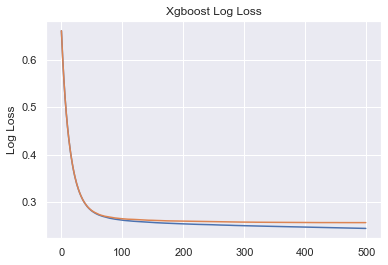

In [46]:
# Looking for overfitting problem

classifier=xgb.XGBClassifier(n_estimators=500,learning_rate=0.05,n_jobs=1,objective='binary:logistic',
                                      booster='gbtree',min_child_weight=11,random_state=0)

eval_set=[(X_train_important, y_train_important),(X_test_important, y_test_important)]
classifier.fit(X_train_important, y_train_important,eval_metric=["error","logloss"],eval_set=eval_set,verbose=True)
prediction_xgb=classifier.predict(X_test_important)
#Trouver les performance 
resultat=classifier.evals_result()
#print(resultat)
epochs=len(resultat['validation_0']['error'])
x_axis=range(0,epochs)
#plot curve
fig,ax=plt.subplots()
ax.plot(x_axis,resultat['validation_0']['logloss'],label='Training curve')
ax.plot(x_axis,resultat['validation_1']['logloss'],label='Test curve')
plt.ylabel('Log Loss')
plt.title('Xgboost Log Loss')
plt.show()

A partir de cette courbe logloss, on pourrait confirmer que notre classifier n'est pas le siège d'un **surapprentissage**.Toutefois, on pourrait définir early_stop_rounds(10% of epochs, epochs~50) pour avoir une meilleure estimation  mais je vais continuer avec mon modèle tel qu'il est.

## Test data_test

In [ ]:
#----------------------------Déscription des fonctions pour la prédiction de camping---------------

In [47]:
def df_feature_importance(df,reg):
    data_train=df[df.reg!=reg]
    X,y = data_train.drop(columns='camping',axis=1),data_train['camping'] 
    X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.1,random_state=0)
    #Build and Tune classifier
    folds = KFold(n_splits=5, shuffle=True, random_state=0)
    params = {'n_estimators':500,'learning_rate':0.05,'objective':'binary:logistic','n_jobs':1,
         'booster':'gbtree'}
    for fold_, (train_idx, valid_idx) in enumerate(folds.split(X,y)):
        train_x, train_y = X.iloc[train_idx,:], y.values[train_idx]
        valid_x, valid_y = X.iloc[valid_idx,:], y.values[valid_idx]
        model = xgb.train(params,xgb.DMatrix(train_x, label=train_y), 200, maximize=False)
    
    best_iter = model.best_iteration
    classifier = xgb.XGBClassifier(**params, num_boost_round=best_iter)
    classifier.fit(X_train, Y_train)
    # Feature importance
    feature_list=list(X_train.columns)
    importances=list(classifier.feature_importances_)
    feature_importances=[(feature,round(importance,2)) for feature, importance in zip(feature_list, importances)]
    # frame with sorted important feature 
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # extract the names of the most important features
    important_feature_names=[feature[0] for feature in feature_importances[:16]] # 16: all these important features have been selected
    #Select the important indices 
    important_indices=[feature_list.index(feature) for feature in important_feature_names]
    return important_indices

In [48]:
def prediction_region_camping(region,df,indices): 
    '''
    Fonction qui renvoie la précision de la prédiction. Eventuellement, on pourrait externaliser les valeurs de prédiction 
    au lieu de la précision.
    Cette fonction prend comme input la DataFrame et la région. Veillez à ce que la région soit de type flot:
    a= 'reg'.0 avec reg={1,12,11,...}
    
    indices: représente une liste des indices des importantes features calculés à partir de la fonction df_feature_importance
    '''
    folds = KFold(n_splits=5, shuffle=True, random_state=0)

    params = {'n_estimators':500,'learning_rate':0.05,'objective':'binary:logistic','n_jobs':1,
         'booster':'gbtree'}

    data_train=df[df.reg!=region]
    data_test=df[df.reg==region]
    
    X,y=data_train.iloc[:,indices], data_train['camping'] 
   
    X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.1,random_state=0)
    
    Y_test_reg=data_test['camping']
    X_test_reg=data_test.iloc[:,indices]
    
    for fold_, (train_idx, valid_idx) in enumerate(folds.split(X,y)):
        train_x, train_y = X.iloc[train_idx,:], y.values[train_idx]
        valid_x, valid_y = X.iloc[valid_idx,:], y.values[valid_idx]
        model = xgb.train(params,xgb.DMatrix(train_x, label=train_y), 200, maximize=False)
        best_iter = model.best_iteration
    classifier = xgb.XGBClassifier(**params, num_boost_round=best_iter) #Choose the best iteration
    classifier.fit(X_train, Y_train)
    predicted=classifier.predict(X_test_reg) 
    precision=1-np.count_nonzero(Y_test_reg - predicted) / len(Y_test_reg - predicted)
    
    return  precision 

In [49]:
indices93=df_feature_importance(df1,93.0)
precision_region_93=prediction_region_camping(93.0,df1,indices93)
print(precision_region_93)

0.7227414330218069


In [50]:
indices53=df_feature_importance(df1,53.0)
precision_region_53=prediction_region_camping(53.0,df1,indices53)
print(precision_region_53)

0.8130914826498423


In [51]:
indices91=df_feature_importance(df1,91.0)
precision_region_91=prediction_region_camping(91.0,df1,indices91)
print(precision_region_91)

0.8401294498381877


In [52]:
indices74=df_feature_importance(df1,74.0)
precision_region_74=prediction_region_camping(74.0,df1,indices74)
print(precision_region_74)

0.8527443105756358


In [53]:
indices72=df_feature_importance(df1,72.0)
precision_region_72=prediction_region_camping(72.0,df1,indices72)
print(precision_region_72)

0.8839441535776614


In [54]:
indices21=df_feature_importance(df1,21.0)
precision_region_21=prediction_region_camping(21.0,df1,indices21)
print(precision_region_21)

0.9593830334190231


In [55]:
indices11=df_feature_importance(df1,11.0)
precision_region_11=prediction_region_camping(11.0,df1,indices11)
print(precision_region_11)

0.92265625


In [56]:
indices22=df_feature_importance(df1,22.0)
precision_region_22=prediction_region_camping(22.0,df1,indices11)
print(precision_region_22)

0.9532955041466609


**La panoplie des précision faible sont à l'origine probablement de la différence de représentation entre le training et le test data.Ceci nécessite éventuellement le recours à des techniques de standardisation poussées hormis que j'ai utilisé StandardScaler et MinMaxScaler auparavant et qui n'ont pas amélioré la précision**

### Analyse de la région 93

In [61]:
df1.groupby(['reg'], as_index=False).agg({'camping': np.average,'score_equipement_de_sante_bv':np.average}).sort_values(by='camping', ascending=False).head(10)

,reg,camping,score_equipement_de_sante_bv
20,93.0,0.372793,2.526480
12,53.0,0.292587,3.086751
19,91.0,0.236893,2.926861
16,74.0,0.208835,3.168675
18,83.0,0.201527,2.527481
17,82.0,0.199792,2.352675
11,52.0,0.195073,2.505992
21,94.0,0.191667,3.005556
14,72.0,0.165358,2.750436
7,31.0,0.151358,1.995472


In [67]:
indices93=df_feature_importance(df1,93.0)

In [112]:
# Pourquoi la reg 93 est plus sollicitée en termes de camping?
df_all=df1.iloc[:,indices93]
#df_all.shape
df_all.groupby('reg').max()

,nb_logement_secondaire_et_occasionnel,seg_dyn_entre,score_urbanite,dep_moyenne_salaires_prof_intermediaire_horaires,dynamique_demographique_bv,nb_etudiants,dep_moyenne_salaires_employe_horaires,dep_moyenne_salaires_ouvrie_horaires,reg_moyenne_salaires_cadre_horaires,seg_cap_fiscale,score_equipement_de_sante_bv,evolution_population,reg_moyenne_salaires_prof_intermediaire_horaires,taux_propriete,moyenne_revnus_fiscaux
reg,,,,,,,,,,,,,,,
11.0,2569.0,5,100.0,14.185000,6,8804.0,9.742553,10.356579,23.685098,1,4.0,9123.0,13.655098,88.0,12850.0
21.0,1479.0,5,87.5,12.566667,6,26018.0,8.839286,9.404762,20.931707,3,4.0,12879.0,12.489024,97.0,10791.0
22.0,2966.0,5,75.0,13.058571,6,19014.0,9.150000,9.721429,21.691034,3,4.0,9836.0,12.673103,91.0,10378.0
23.0,1274.0,5,87.5,13.160494,6,18139.0,8.849383,9.651852,21.640496,3,4.0,10764.0,13.042149,93.0,11079.0
24.0,1654.0,5,87.5,12.729310,6,20063.0,8.969697,9.383673,21.272277,3,4.0,8380.0,12.599505,89.0,11551.5
25.0,7857.0,5,75.0,12.287500,6,19489.0,8.629412,8.924444,21.021569,3,4.0,7390.0,12.200000,92.0,9996.5
26.0,2017.0,5,87.5,12.550000,6,23891.0,8.770370,9.174074,21.221698,3,4.0,7203.0,12.430189,97.0,12710.0
31.0,8233.0,5,87.5,12.448707,6,37365.0,8.700862,9.186207,20.509549,1,4.0,14194.0,12.444562,93.0,9031.5
41.0,1485.0,5,87.5,12.714706,6,19356.0,8.767647,9.340659,21.013953,1,4.0,9378.0,12.571163,100.0,9337.0


In [111]:
#Détermination des critères de jugement !
df_all[df_all.reg==93.0].describe()

,nb_logement_secondaire_et_occasionnel,seg_dyn_entre,score_urbanite,dep_moyenne_salaires_prof_intermediaire_horaires,dynamique_demographique_bv,nb_etudiants,dep_moyenne_salaires_employe_horaires,dep_moyenne_salaires_ouvrie_horaires,reg_moyenne_salaires_cadre_horaires,seg_cap_fiscale,reg,score_equipement_de_sante_bv,evolution_population,reg_moyenne_salaires_prof_intermediaire_horaires,taux_propriete,moyenne_revnus_fiscaux
count,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,9.630000e+02,963.0,963.0,963.000000,963.000000,9.630000e+02,963.000000,963.000000
mean,449.629283,2.653167,17.367601,12.645609,3.072690,353.612669,8.625123,9.165162,2.183514e+01,3.0,93.0,2.526480,75.510903,1.277331e+01,39.903427,9554.362409
std,1600.745936,1.904191,31.178379,0.205374,2.555194,2629.519221,0.123193,0.171092,1.066368e-14,0.0,0.0,1.362581,649.566394,3.554560e-15,15.793694,777.342221
min,3.000000,1.000000,0.000000,12.400000,0.000000,0.000000,8.514286,8.925974,2.183514e+01,3.0,93.0,0.000000,-4174.000000,1.277331e+01,2.000000,8376.500000
25%,46.000000,1.000000,0.000000,12.550000,0.000000,9.000000,8.528000,9.054000,2.183514e+01,3.0,93.0,1.000000,-6.000000,1.277331e+01,28.000000,9192.500000
50%,96.000000,1.000000,0.000000,12.576623,2.000000,35.000000,8.532468,9.207143,2.183514e+01,3.0,93.0,3.000000,2.000000,1.277331e+01,40.000000,9750.500000
75%,229.000000,5.000000,25.000000,12.864151,6.000000,172.500000,8.760000,9.354717,2.183514e+01,3.0,93.0,4.000000,28.000000,1.277331e+01,52.000000,9988.000000
max,23560.000000,5.000000,87.500000,13.044211,6.000000,71159.000000,8.835849,9.444211,2.183514e+01,3.0,93.0,4.000000,16232.000000,1.277331e+01,75.000000,10775.000000


* **Les critères**
- la région 93 possède le nombre le plus important des étudiants (71159 étudiants) avec un nombre considérable de logement secondaire et occasionnel (23560 logement contre 29330, la valeur maximale).


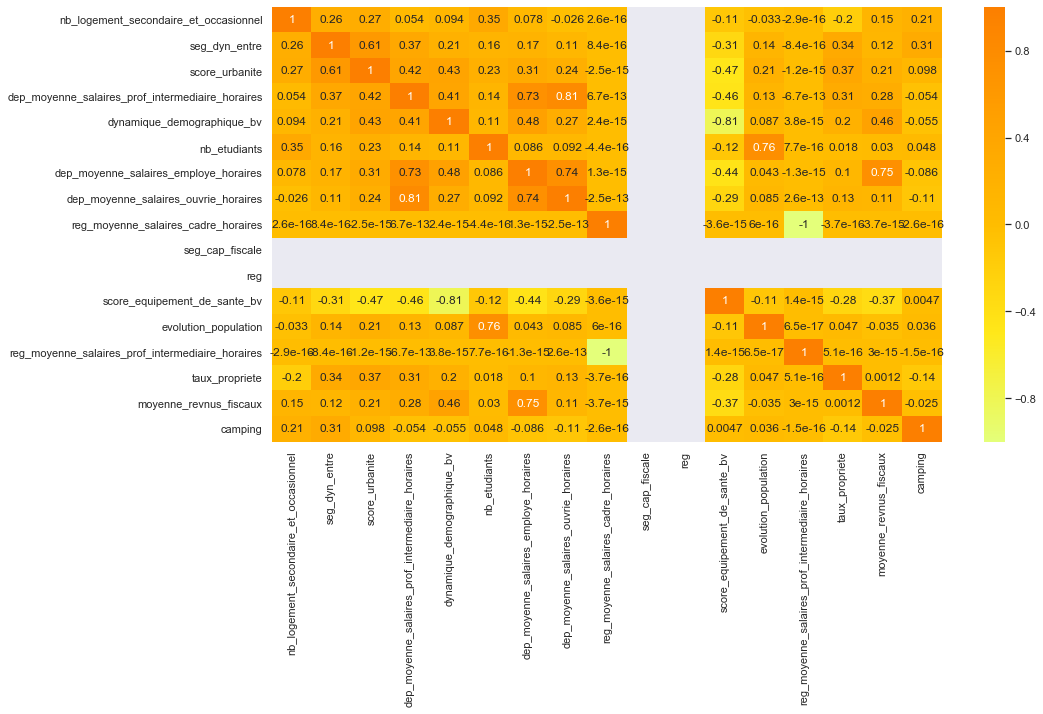

In [120]:
# Matrice de corrélation:
data_93=df1[df1.reg==93.0] # all data for reg=93
Y_93=data_93['camping']
df_93=pd.concat([df_all[df_all.reg==93.0],Y_93],axis=1)# avec les features importantes
#df_93.head(5)
df_93_corr=df_93.corr()
plt.rcParams['figure.figsize']=(15,8)
sns.heatmap(df_93_corr,cmap='Wistia',annot=True)

**On pourrait remarquer que camping est en dépendance linéaire forte avec "seg_dyn_entre" comparant aux autres et qui pourrait éventuellement justifier la sollicitation de cette région pour le camping.**

## Analyse du modèle et conclusions

La problématique n'est pas une simple modélisation supervisée qu'on pourra la résoudre avec une approche "Learn a classifier directly”. En fait , il y a plusieurs variances dans les données ainsi on dispose d'une distribution de variable d'intérêt qui n'est pas équilibrée.
J'ai testé des standardisations avec StandardScaler et MinMaxScaler et je n'ai pas constaté une différence durant la phase d'apprentissage. De ce fait, j'ai gardé le même scaler pour toutes les colonnes.

Finalement, On pourrait disposer d'un classifier xgboost utilisé avec cross_validation pour estimer la prédiction avec une **précision totale=0.90** avec un **roc_auc_score =0.88** dans le cas où on dispose d'une training dataset qui ne prendra pas en compte la region 93.


* Sous jaccente des contraintes d'installation de imblearn et d'autres packages avec la version python 3.5, j'ai essayé de tester un oversampling (sur un Notebook Kaggle[**Private session**]) de la variable d'intérêt "camping" avec l'intégralité des features (91 colonnes) y compris feature_importances_, la précision totale est égale à 0.8956. En fait, cette approche est désormais intéressante mais il faudrait faire attention à la possibilité d'avoir un surapprentissage. On pourrait aussi expliciter ExtratreeClassifier mais il faudrait trouver un compromis pour définir class_weight.

# 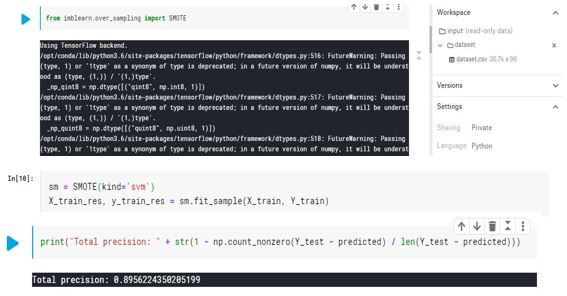

### Pros and cons du modèle 

**Pros**
- Temps de calcul réduit si on compare au training directement avec toutes les features.
- pas de surapprentissage détecté.

**Cons**
- On craint l'existance d'autres outliers dans les data_test.
- Problème de stabilité: Augementer ou diminuer des données de training peut affecter la qualité de la prédiction.

# PERSPECTIVE

### Look up for new approachs...

Cette deuxième approche consiste à promouvoir un autre categorical feature pour combler le non-équilibrage de notre variable d'intérêt.
A partir de la matrice de corrélation, une vision particulière pour "nb_equipement_de_sante_bv" nous a permis de conclure qu'elle est relativement en corrélation forte avec camping d'où l'intérêt de savoir sa distribution exacte.

In [61]:
# exploration de la relation entre camping et score equipement
df_pivot=df1[["score_equipement_de_sante_bv","camping"]]
table=pd.pivot_table(df_pivot,values='camping',
                     index=['score_equipement_de_sante_bv'],columns=['camping'],aggfunc=lambda x: len(x))

table

camping,0,1
score_equipement_de_sante_bv,,
0.0,899,74
1.0,9992,1220
2.0,4310,530
3.0,5428,977
4.0,10857,2262


à partir de TDC, on pourrait remarquer que la class 0 est bien portée majoritairement par le feature score_equipement et joue un rôle déterministe dans la détermination de la valeur de camping.

Dans le prochain modèle, je vais considérer les deux features ensembles et essayer de tuner le calcul. "score_equipement_de_sante_bv" et "camping" possèdent respectivement 5  et 2 classes.

In [121]:
# Approche sans tenir en compte les folds
#----------------------------First Solution--------------------

data_train2=df1[df1.reg!=93.0]
#dataset pour la prédiction de la region 11
data_test2=df1[df1.reg==93.0]


cols=["camping","score_equipement_de_sante_bv"] # considérer deux variables d'intérêt à prédire
X2=data_train2.drop(columns=cols,axis=1)
Y2=data_train2[cols]

#Split_data 
X_train,X_test,Y_train,Y_test=train_test_split(X2,Y2,test_size=0.1,random_state=42)

prediction_xgb=pd.DataFrame(columns=['camping','score_equipement_de_sante_bv']) # Creation d'une dataframe vide
for class_name in cols:
    target_train=Y_train[class_name]
    classifier=xgb.XGBClassifier(n_estimators=500,learning_rate=0.05,n_jobs=1,objective='binary:logistic',
                                      booster='gbtree',min_child_weight=11,random_state=0)
    classifier.fit(X_train,target_train)
    prediction_xgb[class_name]=classifier.predict(X_test)
    
precision_score_equipement=1-np.count_nonzero(Y_test['score_equipement_de_sante_bv'].values - prediction_xgb['score_equipement_de_sante_bv'].values) / len(Y_test['score_equipement_de_sante_bv'] - prediction_xgb['score_equipement_de_sante_bv'])
precision_camping=1-np.count_nonzero(Y_test['camping'] - prediction_xgb['camping']) / len(Y_test['camping'] - prediction_xgb['camping'])
print("Total precision classifier " + str(np.mean(precision_score_equipement+precision_camping)))

Total precision classifier 0.9542119166422072


**la précision totale de ce classifier demeure juste puisqu'on est pas concerté à un surapprentissage.**

 **A méditer ...**

In [63]:
'''
Cette solution est en phase d'expérimentation malgré la précision du classifier est de l'ordre de 0.58 !
''' 
#------------------- Test dataset------------------
data_test=df1[df1.reg==11.0]

#-------------------Train dataset-----------------
data_train_replaced=df1[df1.reg!=11.0]
X=data_train_replaced.drop(columns=['camping','score_equipement_de_sante_bv'],axis=1)
Y=data_train_replaced[["camping","score_equipement_de_sante_bv"]]

#-------------splitting data----------------
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0)
#Y_train=Y_train.astype(int)
Y_train=Y_train['score_equipement_de_sante_bv'].replace({4:0,3:0,2:1}) # Main idea is to equi_sampling the 2 classes| 
                                                                       #Need to find the best approach
Y_test=Y_test['camping']
#-------------train model---------------
classifier=xgb.XGBClassifier(n_estimators=500,learning_rate=0.05,n_jobs=1,objective='binary:logistic',
                                      booster='gbtree')
classifier.fit(X_train,Y_train)
predicted_replace=classifier.predict(X_test)
#----------- metrics---------------
proba=classifier.predict_proba(X_test) 
print("Total precision: " + str(1 - np.count_nonzero(Y_test - predicted_replace) / len(Y_test - predicted_replace)))
print("roc_auc_score is",roc_score)
print('the Confusion_Matrix is:\n')
print(confusion_matrix(Y_test, predicted_replace))